In [3]:
import numpy as np
#%matplotlib notebook
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.core.debugger import set_trace
import warnings
warnings.filterwarnings('ignore')
import random
from sklearn import preprocessing
import tensorflow as tf
from sklearn.metrics import classification_report
import logging

logging.getLogger('tensorflow').disabled = True

# Fasion_MNIST data


In [4]:
from keras.datasets import fashion_mnist

In [5]:
(x_train,y_train),(x_test,y_test) = fashion_mnist.load_data()

4431872/4422102 [==============================] - 0s 0us/step


Observe that we have 60000 sample of 28x28 images for training and 10000 sample images for testing.

In [6]:
print(x_train.shape)
print(x_test.shape)

(60000, 28, 28)
(10000, 28, 28)


We have 10 classifications and in the training they are uniformly distributed.

[9 0 0 ... 3 0 5]


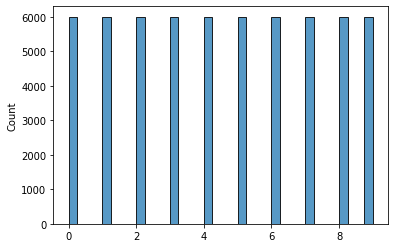

In [7]:
print(y_train)
sns.histplot(y_train)
#sns.histplot(news_test.target,color = "skyblue")
plt.show()

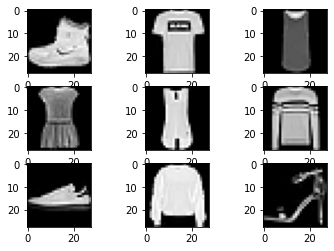

In [8]:
for i in range(9):
  plt.subplot(330+1+i)
  plt.imshow(x_train[i],cmap=plt.get_cmap('gray'))
plt.show()

Vectorize the data

In [9]:
x_train = x_train.reshape(x_train.shape[0],784)
x_test = x_test.reshape(x_test.shape[0],784)

Given that the pixel value range from 1 to 255, convert to float and normalize

In [10]:
def normalization(x):
    nor_matrix = []
    for picture in x:
        new_matrix = picture - np.mean(picture, axis=0)
        new_matrix /= np.std(new_matrix, axis=0)
        nor_matrix.append(new_matrix)
    nor_matrix = np.array(nor_matrix)
    return np.nan_to_num(nor_matrix) + 1e-5

In [11]:
x_train_norm = normalization(x_train)
x_test_norm = normalization(x_test)

Using one hot encoding for class labels

In [12]:
from keras.utils import np_utils
y_train = np_utils.to_categorical(y_train,10)
y_test = np_utils.to_categorical(y_test,10)

# Helper function


In [13]:
def ReLU(o):
  o [o<0 ] = 0
  return o

def ReLU_dr(o):
    o[o<0] = 0
    o[o>=1] = 1
    return o


def leaky_ReLU(x, a=0.02):
    x[x < 0] *= a
    return x

def dleaky_ReLU(x, a=0.02):
    x[x < 0] = a
    x[x >= 0] = 1
    return x

def tanh(o):
    return np.tanh(o)

def tanh_dr(o):
    return 1.0 - np.power(o, 2)

def add_bias(x):
    N = x.shape[0]
    x = np.column_stack([x,np.ones(N)])
    return x

  
def softmax(o):
  l = []
  for i in o:
    nu = np.nan_to_num(np.exp(i-np.max(i)))
    de = np.sum(nu)
    l.append(nu/de)
  return np.array(l)

def cross_entropy(t,y):
  loss=-np.sum(t*np.log(y))
  return loss/float(t.shape[0])


def evaluate_acc(t,y):
   num = 0
   for i in range(len(t)):
      if t[i].argmax() == y[i].argmax():
          num += 1
   return num / len(t) * 100

def batch_select(x,y,n):
  (num_instances,num_features),num_classes = x.shape, y.shape[1]
  n_select = int(num_instances * n)
  inds = random.sample(range(0,num_instances),n)
  x_select,y_select = x[inds],y[inds]
  return x_select,y_select


def evaluate_acc_cnn(t,y):
   num = 0
   for i in range(len(t)):
      if t[i] == y[i]:
          num += 1
   return num / len(t) * 100

def sft_max(y_pred):
    predictions = []
    for sft_max_array in y_pred:
        predictions_output = sft_max_array.tolist().index(max(sft_max_array))
        predictions.append(predictions_output)
    return predictions


    


# MLP

In [14]:
from numpy.core.fromnumeric import shape
class mlp:
    
    def __init__(self, nhid, lhid, ac_fn, ac_d, max_iters,b1,b2,adam,scal_factor,dp_rate):
        
        self.layers = lhid+2
        self.lhid=lhid
        #if lhid >=1 :
        self.nhid = nhid
          #assert len(nhid) == lhid, "hidden layer and given hidden units does not match" 
        self.ac_fn = ac_fn
        self.ac_d= ac_d
        self.max_iters = max_iters
        self.b1=b1
        self.b2=b2
        self.adam=adam
        self.scal_factor=scal_factor
        self.dp_rate = dp_rate
  
    def dp(self,dp_rate,size):
      drop_weight=[]
      for k in range(size):
        if(random.random()<dp_rate):
          drop_weight.append(0)
        else:
          drop_weight.append(1)
      regularize_dp_layer = np.array(drop_weight)*(size/sum(drop_weight))
      return regularize_dp_layer
      
    def feed_forward(self,x,is_last_pred):
      if is_last_pred:
        self.dp_rate=0
      if self.nhid==[]:
        dropout_layer=1
      else:
        dropout_layer=self.dp(self.dp_rate,128)
      self.layer[0]=x
      for i in range (self.layers-1):
            if i == self.layers-2:
              self.layer[i+1] = np.array(softmax(add_bias(np.multiply(self.layer[i],dropout_layer))@self.w[i]))              
            else:
              if i == 0:
                ac = self.ac_fn(np.multiply(add_bias(self.layer[i])@self.w[i],dropout_layer))
              else:
                ac = self.ac_fn(add_bias(np.multiply(self.layer[i],dropout_layer))@self.w[i])
              if self.ac_fn != tanh:
                self.layer[i+1] = ac/np.max(ac)*self.scal_factor
              else:
                self.layer[i+1] = ac


        

    def back_propagation(self,y,lr,b1,b2):

        N = y.shape[0]
        for i in range(self.layers-2,-1,-1):
          if i == self.layers-2:
            err = self.layer[i+1]-y
          else:
            err= (err@self.w[i+1].transpose()[:,:-1])*self.ac_d(self.layer[i+1])
  
          if self.adam == True:
            grad=(1/N)*add_bias(self.layer[i]).transpose()@err
            self.m[i] = b1*self.m[i]+(1-b1)*grad
            self.s[i] = b2*self.s[i]+(1-b2)*np.square(grad)
            self.w[i] = self.w[i]-lr/np.sqrt(self.s[i]+1e-8)*self.m[i]
          else:
            self.w[i] = self.w[i]-lr*grad
  
    
    def fit(self, x, y, lr,n):
        N,D = x.shape
        C = y.shape[1]
        self.x_d = D
        self.y_d = C

        layer = []
        layer.append(np.zeros(D))
        for i in range (self.lhid):
          layer.append(np.zeros(self.nhid[i]))
        layer.append(np.zeros(C))
        self.layer = layer


        layer_d = []
        layer_d.append(D)
        for i in range (self.lhid):
          layer_d.append(self.nhid[i])
        layer_d.append(C)
        self.layer_d = layer_d

        w=[] #initialize the weights
        for i in range(self.layers-1):
          w.append(np.random.rand(layer_d[i]+1,layer_d[i+1]))
        self.w = w

        if self.adam == True:
          m=[] 
          for i in range(self.layers-1):
            m.append(np.zeros(((self.layer_d[i]+1,self.layer_d[i+1]))))
          self.m=m
          
    
          s=[] 
          for i in range(self.layers-1):
            s.append(np.zeros(((self.layer_d[i]+1,self.layer_d[i+1]))))
          self.s=s
       
      
        loss_list = []
        self.loss_list = loss_list

        #training 
        num = 0
        for iter in range(self.max_iters):
          num = num +1
          if num%10  == 0:
            print("training  " +  str(num)  +"  epoches...." )

          x_batch,y_batch = batch_select(x,y,n)
          self.feed_forward(x_batch,is_last_pred=False)        
          
          #cross entropy loss
          loss = cross_entropy(y_batch,self.layer[-1])
          loss_list.append(loss)

          self.back_propagation(y_batch,lr,self.b1,self.b2)
 

        plt.plot(range(self.max_iters),loss_list)
        plt.ylabel('loss')
        plt.xlabel('epoch')
        plt.title('loss over epoches')
        plt.show()

    def predict(self,x,y):
      self.feed_forward(x,is_last_pred=True)
      return self.layer[-1]

   

# CNN

CNN function

In [15]:
def CNN(Normalize,Conlayer,Droplayer,dprate,FuClayer):
  #load and normalize the data
  (x_train,y_train),(x_test,y_test) = fashion_mnist.load_data()
  if Normalize == True:
    x_train = normalization(x_train)
    x_test = normalization(x_test)
  model = tf.keras.models.Sequential() 
  if Conlayer >=1: 
    #Converlutional layer: convert 2D pixel to feature map and setting the parameters
    model.add(tf.keras.layers.Conv2D(
        filters=32,kernel_size=(3, 3),# each kernel s
        strides=(1, 1),#each step is 1 size
        padding='same',#available for padding 0
        activation='relu',#use relu ac function
        input_shape=(28,28,1), #input size channel is 1 since is not rgb
        name="Converlutional_layer1"
        ))

    #Pooling layer, using max pooling method 
    model.add(
        tf.keras.layers.MaxPooling2D(
            pool_size=(2, 2), 
            strides=(2, 2),
            name="Max_pooling_layer1")
            )
    if Droplayer == True:
      #Dropout layer, ignore random neuron in certain rate to prevent overfitting.
      model.add(tf.keras.layers.Dropout(
          rate=dprate,
          name="Droplayer1"))
  if Conlayer==2:
    #add one more layer if 2 Converlutional layer needed
    model.add(tf.keras.layers.Conv2D(
        filters=32,kernel_size=(3, 3),# each kernel s
        strides=(1, 1),#each step is 1 size
        padding='same',#available for padding 0
        activation='relu',#use relu ac function
        input_shape=(28,28,1), #input size channel is 1 since is not rgb
        name="Converlutional_layer2"
        ))
    model.add(
        tf.keras.layers.MaxPooling2D(
            pool_size=(2, 2), 
            strides=(2, 2),
            name="Max_pooling_layer2")
            )
    if Droplayer == True:
      #Dropout layer, ignore random neuron in certain rate to prevent overfitting.
      model.add(tf.keras.layers.Dropout(
          rate=dprate,
          name="Droplayer2"))

  #Flatten layer: reshape the 3D data in to 1d array to connect to full connected layer
  model.add(tf.keras.layers.Flatten())
  if FuClayer >=1:
    #Dense layer(mlp layer, which has similar units and activation function) and use relu as activation function
    model.add(tf.keras.layers.Dense(
        units=128,
        activation='relu', 
        use_bias=True,
        name='first_dence_layer' 
        ))
  if FuClayer ==2:
    model.add(tf.keras.layers.Dense(
        units=128,
        activation='relu', 
        use_bias=True,
        name='Second_dence_layer' 
        ))
    
  #output layer, use softmax to classifie 10 possible output
  model.add(tf.keras.layers.Dense(
      units=10,
      activation='softmax',
      use_bias=True,
      name='output_layer'
      ))

  model.compile(loss=tf.keras.losses.sparse_categorical_crossentropy, #determine the loss by crossentropy
      optimizer=tf.keras.optimizers.Adam(),  # use Adam to update gradiant descent
      metrics=['acc']  #display accuracy
  )

  model.summary()#Show the total procedure

  x_train = np.expand_dims(x_train, -1)
  x_test = np.expand_dims(x_test, -1)

  history = model.fit(x_train, y_train, batch_size=256, epochs=2, validation_split=0.2, verbose=1)

  y_pred_cnn = model.predict(x_test)
  y_output = sft_max(y_pred_cnn)
  
  print("CNN: ",evaluate_acc_cnn(y_output, y_test))


# Experiments MLP


training  10  epoches....
training  20  epoches....
training  30  epoches....
training  40  epoches....
training  50  epoches....
training  60  epoches....
training  70  epoches....
training  80  epoches....
training  90  epoches....
training  100  epoches....


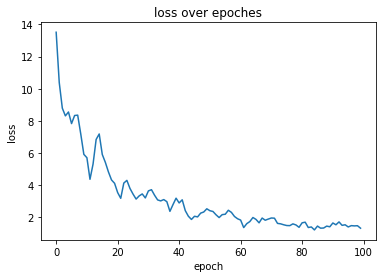

training  10  epoches....
training  20  epoches....
training  30  epoches....
training  40  epoches....
training  50  epoches....
training  60  epoches....
training  70  epoches....
training  80  epoches....
training  90  epoches....
training  100  epoches....
training  110  epoches....
training  120  epoches....
training  130  epoches....
training  140  epoches....
training  150  epoches....
training  160  epoches....
training  170  epoches....
training  180  epoches....
training  190  epoches....
training  200  epoches....
training  210  epoches....
training  220  epoches....
training  230  epoches....
training  240  epoches....
training  250  epoches....
training  260  epoches....
training  270  epoches....
training  280  epoches....
training  290  epoches....
training  300  epoches....
training  310  epoches....
training  320  epoches....
training  330  epoches....
training  340  epoches....
training  350  epoches....
training  360  epoches....
training  370  epoches....
training  

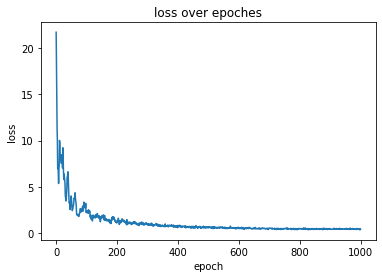

In [ ]:
test_mlp0 = mlp([128],1,ReLU,ReLU_dr,100,0.99,0.999,True,10,0)
test_mlp0.fit(x_train,y_train,0.01,1000)
test_mlp00 = mlp([128],1,ReLU,ReLU_dr,1000,0.99,0.999,True,10,0)
test_mlp00.fit(x_train,y_train,0.01,1000)

In [ ]:
y_pred0 = test_mlp0.predict(x_test_norm,y_test)
accuracy0=evaluate_acc(y_test,y_pred0)
print(accuracy0)
y_pred00 = test_mlp00.predict(x_test_norm,y_test)
accuracy00=evaluate_acc(y_test,y_pred00)
print(accuracy00)

50.349999999999994
56.489999999999995


Using ReLU function, 1 layer hidden unit, adam gradient descent

training  10  epoches....
training  20  epoches....
training  30  epoches....
training  40  epoches....
training  50  epoches....
training  60  epoches....
training  70  epoches....
training  80  epoches....
training  90  epoches....
training  100  epoches....


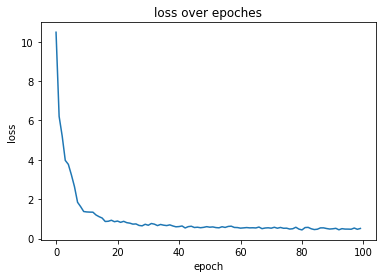

In [ ]:
test_mlp1 = mlp([128],1,ReLU,ReLU_dr,100,0.99,0.999,True,10,0)
test_mlp1.fit(x_train_norm,y_train,0.01,1000)


In [ ]:
y_pred1 = test_mlp1.predict(x_test_norm,y_test)
accuracy1=evaluate_acc(y_test,y_pred1)
print(accuracy1)

81.71000000000001


Using ReLU function, 0 layer hidden unit, adam gradient descent

training  10  epoches....
training  20  epoches....
training  30  epoches....
training  40  epoches....
training  50  epoches....
training  60  epoches....
training  70  epoches....
training  80  epoches....
training  90  epoches....
training  100  epoches....


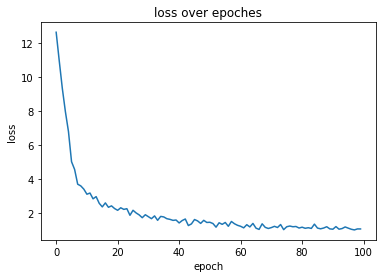

In [ ]:
test_mlp2 = mlp([],0,ReLU,ReLU_dr,100,0.9,0.999,True,10,0)
test_mlp2.fit(x_train_norm,y_train,0.001,1000)


In [ ]:
y_pred2 = test_mlp2.predict(x_test_norm,y_test)
accuracy2=evaluate_acc(y_test,y_pred2)
print(accuracy2)

74.87


Using ReLU function, 2 layer hidden unit, adam gradient descent

training  10  epoches....
training  20  epoches....
training  30  epoches....
training  40  epoches....
training  50  epoches....
training  60  epoches....
training  70  epoches....
training  80  epoches....
training  90  epoches....
training  100  epoches....
training  110  epoches....
training  120  epoches....
training  130  epoches....
training  140  epoches....
training  150  epoches....
training  160  epoches....
training  170  epoches....
training  180  epoches....
training  190  epoches....
training  200  epoches....
training  210  epoches....
training  220  epoches....
training  230  epoches....
training  240  epoches....
training  250  epoches....
training  260  epoches....
training  270  epoches....
training  280  epoches....
training  290  epoches....
training  300  epoches....
training  310  epoches....
training  320  epoches....
training  330  epoches....
training  340  epoches....
training  350  epoches....
training  360  epoches....
training  370  epoches....
training  

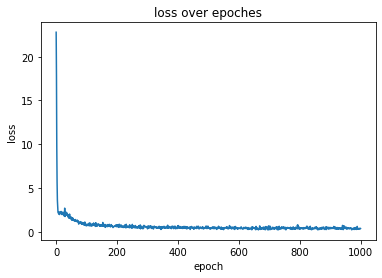

training  10  epoches....
training  20  epoches....
training  30  epoches....
training  40  epoches....
training  50  epoches....
training  60  epoches....
training  70  epoches....
training  80  epoches....
training  90  epoches....
training  100  epoches....
training  110  epoches....
training  120  epoches....
training  130  epoches....
training  140  epoches....
training  150  epoches....
training  160  epoches....
training  170  epoches....
training  180  epoches....
training  190  epoches....
training  200  epoches....
training  210  epoches....
training  220  epoches....
training  230  epoches....
training  240  epoches....
training  250  epoches....
training  260  epoches....
training  270  epoches....
training  280  epoches....
training  290  epoches....
training  300  epoches....
training  310  epoches....
training  320  epoches....
training  330  epoches....
training  340  epoches....
training  350  epoches....
training  360  epoches....
training  370  epoches....
training  

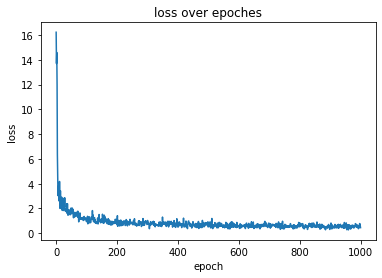

training  10  epoches....
training  20  epoches....
training  30  epoches....
training  40  epoches....
training  50  epoches....
training  60  epoches....
training  70  epoches....
training  80  epoches....
training  90  epoches....
training  100  epoches....
training  110  epoches....
training  120  epoches....
training  130  epoches....
training  140  epoches....
training  150  epoches....
training  160  epoches....
training  170  epoches....
training  180  epoches....
training  190  epoches....
training  200  epoches....
training  210  epoches....
training  220  epoches....
training  230  epoches....
training  240  epoches....
training  250  epoches....
training  260  epoches....
training  270  epoches....
training  280  epoches....
training  290  epoches....
training  300  epoches....
training  310  epoches....
training  320  epoches....
training  330  epoches....
training  340  epoches....
training  350  epoches....
training  360  epoches....
training  370  epoches....
training  

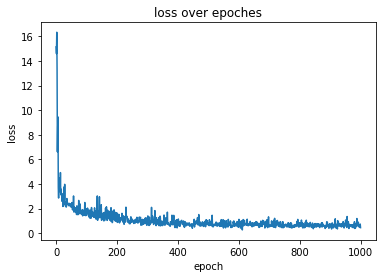

training  10  epoches....
training  20  epoches....
training  30  epoches....
training  40  epoches....
training  50  epoches....
training  60  epoches....
training  70  epoches....
training  80  epoches....
training  90  epoches....
training  100  epoches....
training  110  epoches....
training  120  epoches....
training  130  epoches....
training  140  epoches....
training  150  epoches....
training  160  epoches....
training  170  epoches....
training  180  epoches....
training  190  epoches....
training  200  epoches....
training  210  epoches....
training  220  epoches....
training  230  epoches....
training  240  epoches....
training  250  epoches....
training  260  epoches....
training  270  epoches....
training  280  epoches....
training  290  epoches....
training  300  epoches....
training  310  epoches....
training  320  epoches....
training  330  epoches....
training  340  epoches....
training  350  epoches....
training  360  epoches....
training  370  epoches....
training  

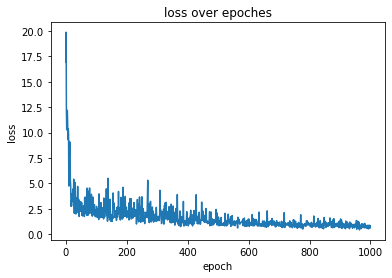

In [ ]:
test_mlp3 = mlp([128,128],2,ReLU,ReLU_dr,1000,0.9,0.9,True,5,0)
test_mlp3.fit(x_train_norm,y_train,0.01,100)
test_mlp4 = mlp([128,128],2,ReLU,ReLU_dr,1000,0.9,0.9,True,5,0.1)
test_mlp4.fit(x_train_norm,y_train,0.01,100)
test_mlp5 = mlp([128,128],2,ReLU,ReLU_dr,1000,0.9,0.9,True,5,0.25)
test_mlp5.fit(x_train_norm,y_train,0.01,100)
test_mlp6 = mlp([128,128],2,ReLU,ReLU_dr,1000,0.9,0.9,True,5,0.5)
test_mlp6.fit(x_train_norm,y_train,0.01,100)


In [ ]:
y_pred3 = test_mlp3.predict(x_test_norm,y_test)
accuracy3=evaluate_acc(y_test,y_pred3)
print(accuracy3)
y_pred4 = test_mlp4.predict(x_test_norm,y_test)
accuracy4=evaluate_acc(y_test,y_pred4)
print(accuracy4)
y_pred5 = test_mlp5.predict(x_test_norm,y_test)
accuracy5=evaluate_acc(y_test,y_pred5)
print(accuracy5)
y_pred6 = test_mlp6.predict(x_test_norm,y_test)
accuracy6=evaluate_acc(y_test,y_pred6)
print(accuracy6)

82.39
82.01
82.69999999999999
76.74


training  10  epoches....
training  20  epoches....
training  30  epoches....
training  40  epoches....
training  50  epoches....
training  60  epoches....
training  70  epoches....
training  80  epoches....
training  90  epoches....
training  100  epoches....
training  110  epoches....
training  120  epoches....
training  130  epoches....
training  140  epoches....
training  150  epoches....
training  160  epoches....
training  170  epoches....
training  180  epoches....
training  190  epoches....
training  200  epoches....
training  210  epoches....
training  220  epoches....
training  230  epoches....
training  240  epoches....
training  250  epoches....
training  260  epoches....
training  270  epoches....
training  280  epoches....
training  290  epoches....
training  300  epoches....
training  310  epoches....
training  320  epoches....
training  330  epoches....
training  340  epoches....
training  350  epoches....
training  360  epoches....
training  370  epoches....
training  

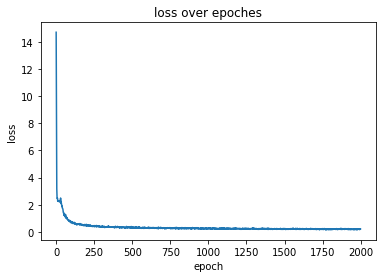

In [ ]:
test_mlp_best = mlp([128,128],2,ReLU,ReLU_dr,2000,0.9,0.9,True,5,0)
test_mlp_best.fit(x_train_norm,y_train,0.01,1000)

In [ ]:
y_pred_best = test_mlp_best.predict(x_test_norm,y_test)
accuracy_best=evaluate_acc(y_test,y_pred_best)
print(accuracy_best)

88.14999999999999


training  10  epoches....
training  20  epoches....
training  30  epoches....
training  40  epoches....
training  50  epoches....
training  60  epoches....
training  70  epoches....
training  80  epoches....
training  90  epoches....
training  100  epoches....
training  110  epoches....
training  120  epoches....
training  130  epoches....
training  140  epoches....
training  150  epoches....
training  160  epoches....
training  170  epoches....
training  180  epoches....
training  190  epoches....
training  200  epoches....
training  210  epoches....
training  220  epoches....
training  230  epoches....
training  240  epoches....
training  250  epoches....
training  260  epoches....
training  270  epoches....
training  280  epoches....
training  290  epoches....
training  300  epoches....
training  310  epoches....
training  320  epoches....
training  330  epoches....
training  340  epoches....
training  350  epoches....
training  360  epoches....
training  370  epoches....
training  

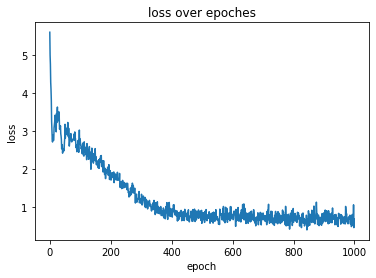

In [ ]:
test_mlp7 = mlp([128,128],2,tanh,tanh_dr,1000,0.99,0.99,True,1,0)
test_mlp7.fit(x_train_norm,y_train,0.01,100)

In [ ]:
y_pred7 = test_mlp7.predict(x_test_norm,y_test)
accuracy7=evaluate_acc(y_test,y_pred7)
print(accuracy7)

76.6


training  10  epoches....
training  20  epoches....
training  30  epoches....
training  40  epoches....
training  50  epoches....
training  60  epoches....
training  70  epoches....
training  80  epoches....
training  90  epoches....
training  100  epoches....
training  110  epoches....
training  120  epoches....
training  130  epoches....
training  140  epoches....
training  150  epoches....
training  160  epoches....
training  170  epoches....
training  180  epoches....
training  190  epoches....
training  200  epoches....
training  210  epoches....
training  220  epoches....
training  230  epoches....
training  240  epoches....
training  250  epoches....
training  260  epoches....
training  270  epoches....
training  280  epoches....
training  290  epoches....
training  300  epoches....
training  310  epoches....
training  320  epoches....
training  330  epoches....
training  340  epoches....
training  350  epoches....
training  360  epoches....
training  370  epoches....
training  

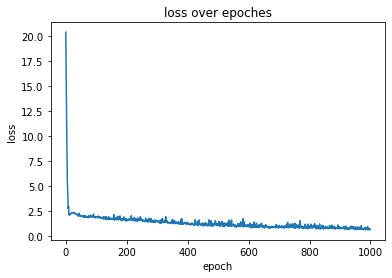

training  10  epoches....
training  20  epoches....
training  30  epoches....
training  40  epoches....
training  50  epoches....
training  60  epoches....
training  70  epoches....
training  80  epoches....
training  90  epoches....
training  100  epoches....
training  110  epoches....
training  120  epoches....
training  130  epoches....
training  140  epoches....
training  150  epoches....
training  160  epoches....
training  170  epoches....
training  180  epoches....
training  190  epoches....
training  200  epoches....
training  210  epoches....
training  220  epoches....
training  230  epoches....
training  240  epoches....
training  250  epoches....
training  260  epoches....
training  270  epoches....
training  280  epoches....
training  290  epoches....
training  300  epoches....
training  310  epoches....
training  320  epoches....
training  330  epoches....
training  340  epoches....
training  350  epoches....
training  360  epoches....
training  370  epoches....
training  

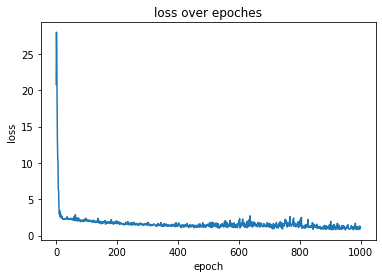

In [ ]:
test_mlp8 = mlp([128,128],2,leaky_ReLU,dleaky_ReLU,1000,0.99,0.99,True,10,0)
test_mlp8.fit(x_train_norm,y_train,0.01,1000)
test_mlp9 = mlp([128,128],2,leaky_ReLU,dleaky_ReLU,1000,0.99,0.99,True,10,0.05)
test_mlp9.fit(x_train_norm,y_train,0.01,1000)

In [ ]:
y_pred8 = test_mlp8.predict(x_test_norm,y_test)
accuracy8=evaluate_acc(y_test,y_pred8)
print(accuracy8)
y_pred9 = test_mlp9.predict(x_test_norm,y_test)
accuracy9=evaluate_acc(y_test,y_pred9)
print(accuracy9)

70.49
71.52


optimize mlp architecture

training  10  epoches....
training  20  epoches....
training  30  epoches....
training  40  epoches....
training  50  epoches....
training  60  epoches....
training  70  epoches....
training  80  epoches....
training  90  epoches....
training  100  epoches....
training  110  epoches....
training  120  epoches....
training  130  epoches....
training  140  epoches....
training  150  epoches....
training  160  epoches....
training  170  epoches....
training  180  epoches....
training  190  epoches....
training  200  epoches....
training  210  epoches....
training  220  epoches....
training  230  epoches....
training  240  epoches....
training  250  epoches....
training  260  epoches....
training  270  epoches....
training  280  epoches....
training  290  epoches....
training  300  epoches....
training  310  epoches....
training  320  epoches....
training  330  epoches....
training  340  epoches....
training  350  epoches....
training  360  epoches....
training  370  epoches....
training  

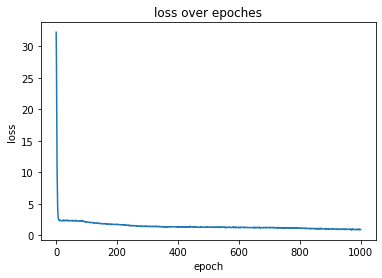

In [15]:
test_mlp10 = mlp([128,128,128],3,ReLU,ReLU_dr,1000,0.9,0.9,True,5,0)
test_mlp10.fit(x_train_norm,y_train,0.01,1000)

training  10  epoches....
training  20  epoches....
training  30  epoches....
training  40  epoches....
training  50  epoches....
training  60  epoches....
training  70  epoches....
training  80  epoches....
training  90  epoches....
training  100  epoches....
training  110  epoches....
training  120  epoches....
training  130  epoches....
training  140  epoches....
training  150  epoches....
training  160  epoches....
training  170  epoches....
training  180  epoches....
training  190  epoches....
training  200  epoches....
training  210  epoches....
training  220  epoches....
training  230  epoches....
training  240  epoches....
training  250  epoches....
training  260  epoches....
training  270  epoches....
training  280  epoches....
training  290  epoches....
training  300  epoches....
training  310  epoches....
training  320  epoches....
training  330  epoches....
training  340  epoches....
training  350  epoches....
training  360  epoches....
training  370  epoches....
training  

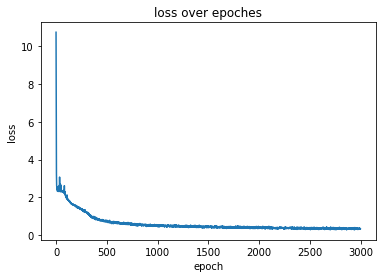

In [15]:
test_mlp11 = mlp([128,128,128],3,ReLU,ReLU_dr,3000,0.9,0.9,True,5,0)
test_mlp11.fit(x_train_norm,y_train,0.01,1000)

In [16]:
y_pred10 = test_mlp10.predict(x_test_norm,y_test)
accuracy10=evaluate_acc(y_test,y_pred10)
print(accuracy10)

61.96


'y_pred11 = test_mlp11.predict(x_test_norm,y_test)\naccuracy11=evaluate_acc(y_test,y_pred11)\nprint(accuracy11)'

In [16]:
y_pred11 = test_mlp11.predict(x_test_norm,y_test)
accuracy11=evaluate_acc(y_test,y_pred11)
print(accuracy11)

85.86


training  10  epoches....
training  20  epoches....
training  30  epoches....
training  40  epoches....
training  50  epoches....
training  60  epoches....
training  70  epoches....
training  80  epoches....
training  90  epoches....
training  100  epoches....
training  110  epoches....
training  120  epoches....
training  130  epoches....
training  140  epoches....
training  150  epoches....
training  160  epoches....
training  170  epoches....
training  180  epoches....
training  190  epoches....
training  200  epoches....
training  210  epoches....
training  220  epoches....
training  230  epoches....
training  240  epoches....
training  250  epoches....
training  260  epoches....
training  270  epoches....
training  280  epoches....
training  290  epoches....
training  300  epoches....
training  310  epoches....
training  320  epoches....
training  330  epoches....
training  340  epoches....
training  350  epoches....
training  360  epoches....
training  370  epoches....
training  

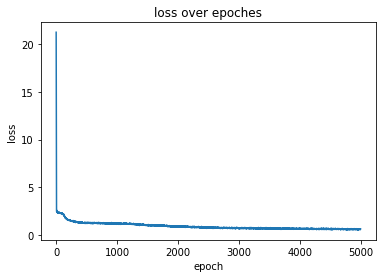

In [17]:
test_mlp12 = mlp([128,128,128],3,ReLU,ReLU_dr,5000,0.9,0.9,True,5,0)
test_mlp12.fit(x_train_norm,y_train,0.01,1000)

In [18]:
y_pred12 = test_mlp12.predict(x_test_norm,y_test)
accuracy12=evaluate_acc(y_test,y_pred12)
print(accuracy12)



77.66


training  10  epoches....
training  20  epoches....
training  30  epoches....
training  40  epoches....
training  50  epoches....
training  60  epoches....
training  70  epoches....
training  80  epoches....
training  90  epoches....
training  100  epoches....
training  110  epoches....
training  120  epoches....
training  130  epoches....
training  140  epoches....
training  150  epoches....
training  160  epoches....
training  170  epoches....
training  180  epoches....
training  190  epoches....
training  200  epoches....
training  210  epoches....
training  220  epoches....
training  230  epoches....
training  240  epoches....
training  250  epoches....
training  260  epoches....
training  270  epoches....
training  280  epoches....
training  290  epoches....
training  300  epoches....
training  310  epoches....
training  320  epoches....
training  330  epoches....
training  340  epoches....
training  350  epoches....
training  360  epoches....
training  370  epoches....
training  

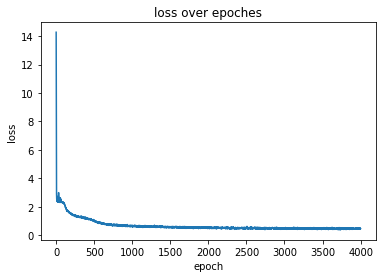

In [16]:
test_mlp13 = mlp([128,128,128],3,ReLU,ReLU_dr,4000,0.9,0.9,True,5,0)
test_mlp13.fit(x_train_norm,y_train,0.01,1000)

training  10  epoches....
training  20  epoches....
training  30  epoches....
training  40  epoches....
training  50  epoches....
training  60  epoches....
training  70  epoches....
training  80  epoches....
training  90  epoches....
training  100  epoches....
training  110  epoches....
training  120  epoches....
training  130  epoches....
training  140  epoches....
training  150  epoches....
training  160  epoches....
training  170  epoches....
training  180  epoches....
training  190  epoches....
training  200  epoches....
training  210  epoches....
training  220  epoches....
training  230  epoches....
training  240  epoches....
training  250  epoches....
training  260  epoches....
training  270  epoches....
training  280  epoches....
training  290  epoches....
training  300  epoches....
training  310  epoches....
training  320  epoches....
training  330  epoches....
training  340  epoches....
training  350  epoches....
training  360  epoches....
training  370  epoches....
training  

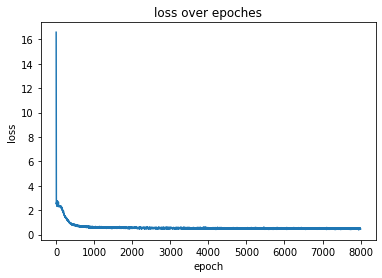

In [17]:
test_mlp14 = mlp([128,128,128],3,ReLU,ReLU_dr,8000,0.9,0.9,True,5,0)
test_mlp14.fit(x_train_norm,y_train,0.01,1000)

In [18]:
y_pred13 = test_mlp13.predict(x_test_norm,y_test)
accuracy13=evaluate_acc(y_test,y_pred13)
print(accuracy13)
y_pred14 = test_mlp14.predict(x_test_norm,y_test)
accuracy14=evaluate_acc(y_test,y_pred14)
print(accuracy14)

82.11
80.25999999999999


training  10  epoches....
training  20  epoches....
training  30  epoches....
training  40  epoches....
training  50  epoches....
training  60  epoches....
training  70  epoches....
training  80  epoches....
training  90  epoches....
training  100  epoches....
training  110  epoches....
training  120  epoches....
training  130  epoches....
training  140  epoches....
training  150  epoches....
training  160  epoches....
training  170  epoches....
training  180  epoches....
training  190  epoches....
training  200  epoches....
training  210  epoches....
training  220  epoches....
training  230  epoches....
training  240  epoches....
training  250  epoches....
training  260  epoches....
training  270  epoches....
training  280  epoches....
training  290  epoches....
training  300  epoches....
training  310  epoches....
training  320  epoches....
training  330  epoches....
training  340  epoches....
training  350  epoches....
training  360  epoches....
training  370  epoches....
training  

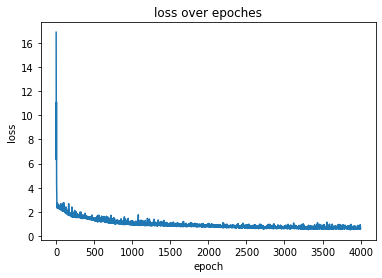

In [21]:
test_mlp15 = mlp([128,128,128],3,ReLU,ReLU_dr,4000,0.9,0.9,True,5,0.2)
test_mlp15.fit(x_train_norm,y_train,0.01,1000)

In [22]:
y_pred15 = test_mlp15.predict(x_test_norm,y_test)
accuracy15=evaluate_acc(y_test,y_pred15)
print(accuracy15)

77.97


training  10  epoches....
training  20  epoches....
training  30  epoches....
training  40  epoches....
training  50  epoches....
training  60  epoches....
training  70  epoches....
training  80  epoches....
training  90  epoches....
training  100  epoches....
training  110  epoches....
training  120  epoches....
training  130  epoches....
training  140  epoches....
training  150  epoches....
training  160  epoches....
training  170  epoches....
training  180  epoches....
training  190  epoches....
training  200  epoches....
training  210  epoches....
training  220  epoches....
training  230  epoches....
training  240  epoches....
training  250  epoches....
training  260  epoches....
training  270  epoches....
training  280  epoches....
training  290  epoches....
training  300  epoches....
training  310  epoches....
training  320  epoches....
training  330  epoches....
training  340  epoches....
training  350  epoches....
training  360  epoches....
training  370  epoches....
training  

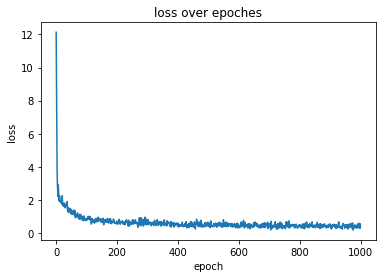

77.21000000000001
training  10  epoches....
training  20  epoches....
training  30  epoches....
training  40  epoches....
training  50  epoches....
training  60  epoches....
training  70  epoches....
training  80  epoches....
training  90  epoches....
training  100  epoches....
training  110  epoches....
training  120  epoches....
training  130  epoches....
training  140  epoches....
training  150  epoches....
training  160  epoches....
training  170  epoches....
training  180  epoches....
training  190  epoches....
training  200  epoches....
training  210  epoches....
training  220  epoches....
training  230  epoches....
training  240  epoches....
training  250  epoches....
training  260  epoches....
training  270  epoches....
training  280  epoches....
training  290  epoches....
training  300  epoches....
training  310  epoches....
training  320  epoches....
training  330  epoches....
training  340  epoches....
training  350  epoches....
training  360  epoches....
training  370  epoc

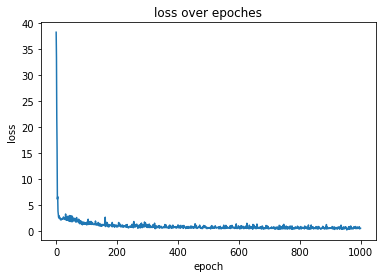

79.55
training  10  epoches....
training  20  epoches....
training  30  epoches....
training  40  epoches....
training  50  epoches....
training  60  epoches....
training  70  epoches....
training  80  epoches....
training  90  epoches....
training  100  epoches....
training  110  epoches....
training  120  epoches....
training  130  epoches....
training  140  epoches....
training  150  epoches....
training  160  epoches....
training  170  epoches....
training  180  epoches....
training  190  epoches....
training  200  epoches....
training  210  epoches....
training  220  epoches....
training  230  epoches....
training  240  epoches....
training  250  epoches....
training  260  epoches....
training  270  epoches....
training  280  epoches....
training  290  epoches....
training  300  epoches....
training  310  epoches....
training  320  epoches....
training  330  epoches....
training  340  epoches....
training  350  epoches....
training  360  epoches....
training  370  epoches....
trai

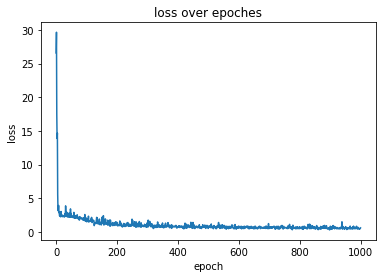

79.16
training  10  epoches....
training  20  epoches....
training  30  epoches....
training  40  epoches....
training  50  epoches....
training  60  epoches....
training  70  epoches....
training  80  epoches....
training  90  epoches....
training  100  epoches....
training  110  epoches....
training  120  epoches....
training  130  epoches....
training  140  epoches....
training  150  epoches....
training  160  epoches....
training  170  epoches....
training  180  epoches....
training  190  epoches....
training  200  epoches....
training  210  epoches....
training  220  epoches....
training  230  epoches....
training  240  epoches....
training  250  epoches....
training  260  epoches....
training  270  epoches....
training  280  epoches....
training  290  epoches....
training  300  epoches....
training  310  epoches....
training  320  epoches....
training  330  epoches....
training  340  epoches....
training  350  epoches....
training  360  epoches....
training  370  epoches....
trai

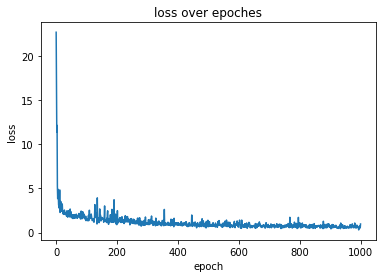

77.9
training  10  epoches....
training  20  epoches....
training  30  epoches....
training  40  epoches....
training  50  epoches....
training  60  epoches....
training  70  epoches....
training  80  epoches....
training  90  epoches....
training  100  epoches....
training  110  epoches....
training  120  epoches....
training  130  epoches....
training  140  epoches....
training  150  epoches....
training  160  epoches....
training  170  epoches....
training  180  epoches....
training  190  epoches....
training  200  epoches....
training  210  epoches....
training  220  epoches....
training  230  epoches....
training  240  epoches....
training  250  epoches....
training  260  epoches....
training  270  epoches....
training  280  epoches....
training  290  epoches....
training  300  epoches....
training  310  epoches....
training  320  epoches....
training  330  epoches....
training  340  epoches....
training  350  epoches....
training  360  epoches....
training  370  epoches....
train

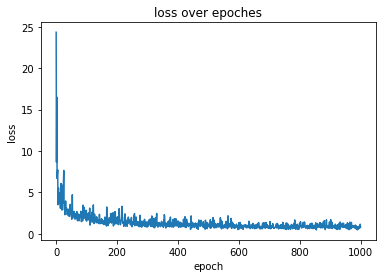

79.27
training  10  epoches....
training  20  epoches....
training  30  epoches....
training  40  epoches....
training  50  epoches....
training  60  epoches....
training  70  epoches....
training  80  epoches....
training  90  epoches....
training  100  epoches....
training  110  epoches....
training  120  epoches....
training  130  epoches....
training  140  epoches....
training  150  epoches....
training  160  epoches....
training  170  epoches....
training  180  epoches....
training  190  epoches....
training  200  epoches....
training  210  epoches....
training  220  epoches....
training  230  epoches....
training  240  epoches....
training  250  epoches....
training  260  epoches....
training  270  epoches....
training  280  epoches....
training  290  epoches....
training  300  epoches....
training  310  epoches....
training  320  epoches....
training  330  epoches....
training  340  epoches....
training  350  epoches....
training  360  epoches....
training  370  epoches....
trai

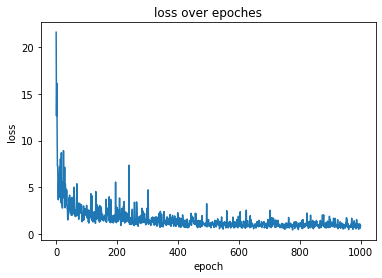

72.64
training  10  epoches....
training  20  epoches....
training  30  epoches....
training  40  epoches....
training  50  epoches....
training  60  epoches....
training  70  epoches....
training  80  epoches....
training  90  epoches....
training  100  epoches....
training  110  epoches....
training  120  epoches....
training  130  epoches....
training  140  epoches....
training  150  epoches....
training  160  epoches....
training  170  epoches....
training  180  epoches....
training  190  epoches....
training  200  epoches....
training  210  epoches....
training  220  epoches....
training  230  epoches....
training  240  epoches....
training  250  epoches....
training  260  epoches....
training  270  epoches....
training  280  epoches....
training  290  epoches....
training  300  epoches....
training  310  epoches....
training  320  epoches....
training  330  epoches....
training  340  epoches....
training  350  epoches....
training  360  epoches....
training  370  epoches....
trai

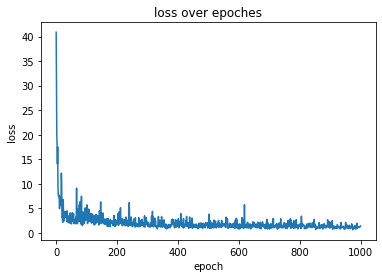

69.32000000000001
training  10  epoches....
training  20  epoches....
training  30  epoches....
training  40  epoches....
training  50  epoches....
training  60  epoches....
training  70  epoches....
training  80  epoches....
training  90  epoches....
training  100  epoches....
training  110  epoches....
training  120  epoches....
training  130  epoches....
training  140  epoches....
training  150  epoches....
training  160  epoches....
training  170  epoches....
training  180  epoches....
training  190  epoches....
training  200  epoches....
training  210  epoches....
training  220  epoches....
training  230  epoches....
training  240  epoches....
training  250  epoches....
training  260  epoches....
training  270  epoches....
training  280  epoches....
training  290  epoches....
training  300  epoches....
training  310  epoches....
training  320  epoches....
training  330  epoches....
training  340  epoches....
training  350  epoches....
training  360  epoches....
training  370  epoc

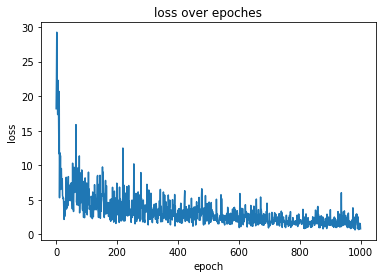

75.64
training  10  epoches....
training  20  epoches....
training  30  epoches....
training  40  epoches....
training  50  epoches....
training  60  epoches....
training  70  epoches....
training  80  epoches....
training  90  epoches....
training  100  epoches....
training  110  epoches....
training  120  epoches....
training  130  epoches....
training  140  epoches....
training  150  epoches....
training  160  epoches....
training  170  epoches....
training  180  epoches....
training  190  epoches....
training  200  epoches....
training  210  epoches....
training  220  epoches....
training  230  epoches....
training  240  epoches....
training  250  epoches....
training  260  epoches....
training  270  epoches....
training  280  epoches....
training  290  epoches....
training  300  epoches....
training  310  epoches....
training  320  epoches....
training  330  epoches....
training  340  epoches....
training  350  epoches....
training  360  epoches....
training  370  epoches....
trai

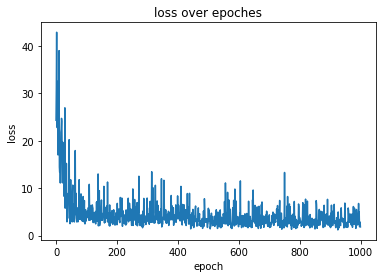

64.60000000000001
training  10  epoches....
training  20  epoches....
training  30  epoches....
training  40  epoches....
training  50  epoches....
training  60  epoches....
training  70  epoches....
training  80  epoches....
training  90  epoches....
training  100  epoches....
training  110  epoches....
training  120  epoches....
training  130  epoches....
training  140  epoches....
training  150  epoches....
training  160  epoches....
training  170  epoches....
training  180  epoches....
training  190  epoches....
training  200  epoches....
training  210  epoches....
training  220  epoches....
training  230  epoches....
training  240  epoches....
training  250  epoches....
training  260  epoches....
training  270  epoches....
training  280  epoches....
training  290  epoches....
training  300  epoches....
training  310  epoches....
training  320  epoches....
training  330  epoches....
training  340  epoches....
training  350  epoches....
training  360  epoches....
training  370  epoc

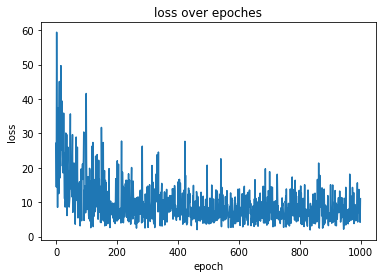

51.849999999999994


In [ ]:
accuracy_dprate = []
for i in range(10):
  test_mlpi = mlp([128,128],2,ReLU,ReLU_dr,1000,0.9,0.9,True,5,i/10)
  test_mlpi.fit(x_train_norm,y_train,0.01,100)
  y_predi = test_mlpi.predict(x_test_norm,y_test)
  accuracyi=evaluate_acc(y_test,y_predi)
  accuracy_dprate.append(accuracyi)
  print(accuracyi)


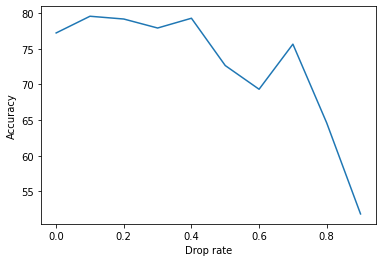

In [28]:
dprate = []
for i in range(10):
  dprate.append(i/10)
l = plt.plot(dprate, accuracy_dprate)
plt.xlabel('Drop rate')
plt.ylabel('Accuracy')
plt.show()


# Experiment CNN

No Normalize 2 Convultional layer 2 Full connected layer and dropout rate=0.25

In [ ]:
CNN(Normalize=False,Conlayer=2,Droplayer=True,dprate=0.25,FuClayer=2)

Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Converlutional_layer1 (Conv  (None, 28, 28, 32)       320       
 2D)                                                             
                                                                 
 Max_pooling_layer1 (MaxPool  (None, 14, 14, 32)       0         
 ing2D)                                                          
                                                                 
 Droplayer1 (Dropout)        (None, 14, 14, 32)        0         
                                                                 
 Converlutional_layer2 (Conv  (None, 14, 14, 32)       9248      
 2D)                                                             
                                                                 
 Max_pooling_layer2 (MaxPool  (None, 7, 7, 32)         0         
 ing2D)                                              

Normalize 2 Convultional layer 2 Full connected layer and dropout rate=0.25

In [ ]:
CNN(Normalize=True,Conlayer=2,Droplayer=True,dprate=0.25,FuClayer=2)

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Converlutional_layer1 (Conv  (None, 28, 28, 32)       320       
 2D)                                                             
                                                                 
 Max_pooling_layer1 (MaxPool  (None, 14, 14, 32)       0         
 ing2D)                                                          
                                                                 
 Droplayer1 (Dropout)        (None, 14, 14, 32)        0         
                                                                 
 Converlutional_layer2 (Conv  (None, 14, 14, 32)       9248      
 2D)                                                             
                                                                 
 Max_pooling_layer2 (MaxPool  (None, 7, 7, 32)         0         
 ing2D)                                              

Normalize 2 Convultional layer 2 Full connected layer without dropout


In [ ]:
CNN(Normalize=True,Conlayer=2,Droplayer=False,dprate=0,FuClayer=2)

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Converlutional_layer1 (Conv  (None, 28, 28, 32)       320       
 2D)                                                             
                                                                 
 Max_pooling_layer1 (MaxPool  (None, 14, 14, 32)       0         
 ing2D)                                                          
                                                                 
 Converlutional_layer2 (Conv  (None, 14, 14, 32)       9248      
 2D)                                                             
                                                                 
 Max_pooling_layer2 (MaxPool  (None, 7, 7, 32)         0         
 ing2D)                                                          
                                                                 
 flatten_12 (Flatten)        (None, 1568)            

Normalize 1 Convultional layer 1 Full connected layer and dprate=0.25 


In [ ]:
CNN(Normalize=True,Conlayer=1,Droplayer=True,dprate=0.25,FuClayer=1)

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Converlutional_layer1 (Conv  (None, 28, 28, 32)       320       
 2D)                                                             
                                                                 
 Max_pooling_layer1 (MaxPool  (None, 14, 14, 32)       0         
 ing2D)                                                          
                                                                 
 Droplayer1 (Dropout)        (None, 14, 14, 32)        0         
                                                                 
 flatten_13 (Flatten)        (None, 6272)              0         
                                                                 
 first_dence_layer (Dense)   (None, 128)               802944    
                                                                 
 output_layer (Dense)        (None, 10)              